# NLP-Milestone
many-to-one task : 
- long sentences -> Objective of sentence


In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np
import os

Get data : [PubMed200k RCT](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [2]:
# start with 20k dataset with replace number by @ sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'
filepath = [ os.path.join(data_dir, file) for file in os.listdir(data_dir) ]
filepath

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign\\dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign\\test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign\\train.txt']

## Preprocess data

In [3]:
# read in all line of target text file
def get_lines(filepath):
    '''
    Read text file and return the lines as a list.
    '''
    with open(filepath, 'r') as file :
        return file.readlines()


train_lines = get_lines(filepath[2])
print(train_lines[:5])

['###24293578\n', 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n', 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n', 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n', 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n']


In [4]:
len(train_lines)

210040

```
[{'line_number' : 0 ,
   'target' : 'OBJECTIVE',
   'text' : 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .'
   'total_lines' : 5}, # total lines in each Abstract
   {''line_number' : 1, 
   .....
}]
```

In [5]:
def preprocess_text(filepath):
    '''
    change long lines to this format
    [{'line_number' : 0 ,
    'target' : 'OBJECTIVE',
    'text' : 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in 
              improving pain , mobility , and systemic low-grade inflammation in the short term 
              and whether the effect would be sustained at @ weeks in older adults with moderate 
              to severe knee osteoarthritis ( OA ) .'
    'total_lines' : 5}, # total lines in each Abstract
    {''line_number' : 1, 
    .....
    }]
    '''
    input_lines = get_lines(filepath)
    abstract_lines = '' # to save 1 abstract 
    abstract_samples = []

    for line in input_lines :
        if line.startswith('###') : #heading of each Abstract
            abstract_id = line 
            abstract_lines = '' # reset old Abstract
        elif line.isspace(): # if a new line (last abstract has space)
            abstract_split = abstract_lines.splitlines() # split Abstract into seperate line

            # loop for content in each Abstract
            for abstract_line_number, abstract_line in enumerate(abstract_split) :
                line_data = {} # for each target and text
                target_text = abstract_line.split('\t') # target and text
                line_data['line_number'] = abstract_line_number
                line_data['target'] = target_text[0]
                line_data['text'] = target_text[1].lower()
                line_data['total_lines'] = len(abstract_split) - 1 # start from zero
                abstract_samples.append(line_data) # add to list

        # content for each abtract
        else :
            abstract_lines += line

    return abstract_samples

In [6]:
train_samples = preprocess_text(filepath[2])
val_samples = preprocess_text(filepath[0])
test_samples = preprocess_text(filepath[1])
train_samples[9:13]

[{'line_number': 9,
  'target': 'RESULTS',
  'text': 'these differences remained significant at @ weeks .',
  'total_lines': 11},
 {'line_number': 10,
  'target': 'RESULTS',
  'text': 'the outcome measures in rheumatology clinical trials-osteoarthritis research society international responder rate was @ % in the intervention group and @ % in the placebo group ( p < @ ) .',
  'total_lines': 11},
 {'line_number': 11,
  'target': 'CONCLUSIONS',
  'text': 'low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee oa ( clinicaltrials.gov identifier nct@ ) .',
  'total_lines': 11},
 {'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'emotional eating is associated with overeating and the development of obesity .',
  'total_lines': 10}]

In [7]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [8]:
# Create DataFrame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [9]:
train_df.value_counts('target')

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
dtype: int64

In [10]:
# feature of data
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

### Make numeric labels

In [11]:
from sklearn.preprocessing import OneHotEncoder # or LabelEncoder(1D data)return a number for each class

onehot_encoder = OneHotEncoder(sparse=False) # to compatible with Tensorflow
train_labels = onehot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels = onehot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels = onehot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
print(train_labels[:5], train_labels.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]] (180040, 5)


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_ = label_encoder.fit_transform(train_df['target'])
val_labels_ = label_encoder.transform(val_df['target'])
test_labels_ = label_encoder.transform(test_df['target'])
print(train_labels_[:5], train_labels_.shape)

[3 2 2 2 2] (180040,)


In [13]:
class_name = label_encoder.classes_
print(onehot_encoder.categories_[0])
print(label_encoder.classes_)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


## Build Model Part

In [14]:
# create evaluation function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_score(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision, recall, f1_score = precision_recall_fscore_support(y_true, y_preds, average='weighted')[:-1]
    evaluation_dict = {'accuracy':accuracy,'precision':precision,'recall':recall,'f1_score':f1_score}
    return evaluation_dict

### baseline : Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

model_0 = Pipeline([ 
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels_) # naive bayes handle 1D targer

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

> if using onehot_encoder : ```ValueError: y should be a 1d array, got an array of shape (180040, 5) instead.```

In [16]:
# make prediction 
baseline_preds = model_0.predict(val_sentences)
baseline_score = evaluate_score(val_labels_, baseline_preds)
baseline_score

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

### Deep sequence models

In [17]:
import tensorflow as tf
from keras import layers

#how long is each sentence on average ?
sentences_lens = [len(sentences.split()) for sentences in train_sentences] 
avg_sentences = np.mean(sentences_lens)
avg_sentences

26.338269273494777

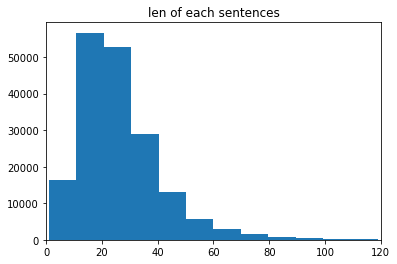

In [18]:
plt.hist(sentences_lens, bins=30)
plt.title('len of each sentences')
plt.xlim([0, 120]);

In [19]:
output_seg_len = int(np.percentile(sentences_lens, 95)) # 95% percentile (make sure don't cut many information off)
output_seg_len # just missed 5% 

55

text_vectorizer: text to number (like ordinal encoder)

In [20]:
#create text vectorizer layer (text to number)
max_vocab = 68000 # from the paper

In [21]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_vocab, 
                             output_sequence_length=output_seg_len)

#adapt to training data
text_vectorizer.adapt(train_sentences)

In [22]:
#test out text_vectorizer
import random
sample = random.choice(train_sentences)
print(f'Text:\n{sample}\n')
print(f'Length of text: {len(sample)}')
print(f'Vectorized:\n{text_vectorizer(sample)}')

Text:
secondary outcomes will include monthly clinic visits , provision of lifestyle advice , use of antihypertensive medications and use of aspirin .

Length of text: 144
Vectorized:
[ 151   75   95  637 1097  859  620 2191    4  839 1589   87    4 2889
 1098    3   87    4 1271    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [23]:
# how many word in training
vocab_list = text_vectorizer.get_vocabulary()
length_vocab = len(vocab_list)
print('Number of vocab :',length_vocab)
print('Most common word :',vocab_list[:10])
print('Least common word :',vocab_list[-10:])

Number of vocab : 64841
Most common word : ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common word : ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


embedding: (relavent number word by word, randomize number first and train like weights)

In [24]:
#token embedding layer
token_embed = layers.Embedding(input_dim=length_vocab, 
                               output_dim=128, # dimetion of output
                               mask_zero= True, # will do more efficient computing (when a lot of zero in matrix)
                               name='token_embedding')

In [25]:
#show example embeding
print(f'Text : {sample}')
vec_sample = text_vectorizer([sample])
print(f'Vectorized:\n{vec_sample}')
print(f' shape : {vec_sample.shape}\n')
em_sample = token_embed(vec_sample)
print(f'Embedded:\n{em_sample[0,:5,:6]}')
print(f' shape : {em_sample.shape}')

Text : secondary outcomes will include monthly clinic visits , provision of lifestyle advice , use of antihypertensive medications and use of aspirin .
Vectorized:
[[ 151   75   95  637 1097  859  620 2191    4  839 1589   87    4 2889
  1098    3   87    4 1271    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
 shape : (1, 55)

Embedded:
[[-0.0357766   0.03960489 -0.00365805  0.01212858  0.02534685  0.02814177]
 [-0.00933223  0.03839954  0.04976356  0.04395633 -0.01316857 -0.017798  ]
 [-0.00492414  0.01663733  0.03320781 -0.02206324  0.00894047  0.00964206]
 [-0.04341823  0.04353614  0.02993505  0.02088311 -0.03778863 -0.01267475]
 [-0.03559492  0.04282511 -0.02591112  0.03565272 -0.03570473  0.04577294]]
 shape : (1, 55, 128)


<h5>Create datasets : making more efficient to load and train model</h5>

In [26]:
#Turn out data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [27]:
#making more efficien to load and train model
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # auto prefetch many as you can
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # auto prefetch many as you can
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # auto prefetch many as you can

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1 : ConV1D

In [28]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vector = text_vectorizer(inputs)
token_embeder = token_embed(text_vector)
x = layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(token_embeder)
x = layers.GlobalAveragePooling1D()(x) 
outputs = layers.Dense(5, activation='softmax')(x)
model_1 = keras.Model(inputs, outputs)

model_1.summary()
model_1.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)
hist_1 = model_1.fit(train_dataset, 
                     validation_data=val_dataset, 
                     steps_per_epoch=int(len(train_dataset) *.1),
                     validation_steps = int(len(val_dataset) *.1),
                     epochs=5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 32)            20512     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 165   

In [29]:
model_1_proba = model_1.predict(val_dataset)
model_1_preds = tf.argmax(model_1_proba, axis=1)
print(model_1_preds[:5])

tf.Tensor([0 0 3 2 2], shape=(5,), dtype=int64)


In [30]:
model_1_result = evaluate_score(val_labels_, model_1_preds)
model_1_result

{'accuracy': 0.7982920693764067,
 'precision': 0.797458591333494,
 'recall': 0.7982920693764067,
 'f1_score': 0.7952949209889866}

### Model 2 : Feature extraction
check : [Universal sentences encoder (USE)](https://tfhub.dev/google/universal-sentence-encoder/4)

embedding layers learned from many sentences.

In [ ]:
import tensorflow_hub as hub

embed_hub_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                                  trainable=False, name='USE')

In [31]:
#test on sentence
print(f'text : {sample}')
sample_embed = embed_hub_layer([sample])
print(f'embeded :\n{sample_embed}\n{sample_embed.shape}') #512 long feature vector

secondary outcomes will include monthly clinic visits , provision of lifestyle advice , use of antihypertensive medications and use of aspirin .


In [ ]:
#modeling with USE
inputs = layers.Input(shape=[], dtype='string') # [] = any amount of sentences
pretrained_embed = embed_hub_layer(inputs) # tokenize text to 512 long vector
x = layers.Dense(128, activation='relu')(pretrained_embed)
# can add more layer if you want
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)
hist_2 = model_2.fit(train_dataset, 
                     validation_data=val_dataset, 
                     steps_per_epoch=int(len(train_dataset) *.1),
                     validation_steps = int(len(val_dataset) *.1),
                     epochs=5)

### Model 3 : Conv1D with Character embedding

<img src="https://www.researchgate.net/profile/M-Kumar-2/publication/321503621/figure/fig2/AS:594531682635776@1518758807406/Character-based-embedding-methodology.png"  width=500px />

In [36]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [39]:
# make function into character
def split_char(sentence):
    return ' '.join(list(sentence))

split_char(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [43]:
#split sequence-level into character-lavel
train_char = [split_char(sentence) for sentence in train_sentences]
val_char = [split_char(sentence) for sentence in val_sentences]
test_char = [split_char(sentence) for sentence in test_sentences]

In [53]:
#what the average charater length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

290


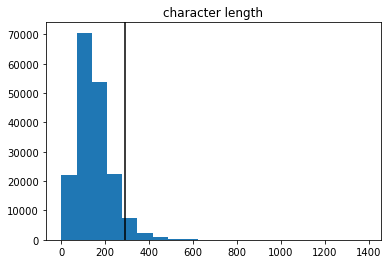

In [64]:
plt.hist(char_lens, bins=20)
plt.title('character length')
#find what character length what cover 95 percentile
output_seg_char_len = int(np.percentile(char_lens, 95))
plt.axvline(output_seg_char_len, c='black')
print(output_seg_char_len);

In [67]:
#get all character 
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [80]:
#create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add for space and OOV(UNK)
char_vectorize = TextVectorization(max_tokens=NUM_CHAR_TOKENS, output_sequence_length=output_seg_char_len,
                                    name='char-vec')

In [81]:
#adapt to training char
char_vectorize.adapt(train_char)

In [82]:
#check charactor vocab stat
char_vocab = char_vectorize.get_vocabulary()
print(f'number of char : {len(char_vocab)}')
print(f'most common char : {char_vocab[:5]}')
print(f'least common char : {char_vocab[-5:]}')

number of char : 28
most common char : ['', '[UNK]', 'e', 't', 'i']
least common char : ['k', 'x', 'z', 'q', 'j']


In [97]:
#test char-vectorizer
sample = random.choice(train_char)
print(f'text : {len(sample)}\n{sample}')
char_vec = char_vectorize([sample])
print(f'vectorized char : {len(char_vec[0])}\n{char_vec[0]}')

text : 307
m u s c l e   s t r e n g t h   o f   t h e   i r   o r   e r   w a s   n o t   s i g n i f i c a n t l y   d i f f e r e n t   w h e n   c o m p a r i n g   n e u t r a l   @   t o   t h e   m i d - r a n g e   p o s i t i o n   a n d   a t   t h e i r   m o s t   l e n g t h e n e d   p o s i t i o n   .
vectorized char : 290
[15 16  9 11 12  2  9  3  8  2  6 18  3 13  7 17  3 13  2  4  8  7  8  2
  8 20  5  9  6  7  3  9  4 18  6  4 17  4 11  5  6  3 12 19 10  4 17 17
  2  8  2  6  3 20 13  2  6 11  7 15 14  5  8  4  6 18  6  2 16  3  8  5
 12  3  7  3 13  2 15  4 10  8  5  6 18  2 14  7  9  4  3  4  7  6  5  6
 10  5  3  3 13  2  4  8 15  7  9  3 12  2  6 18  3 13  2  6  2 10 14  7
  9  4  3  4  7  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  

In [99]:
#create char-level embedding
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different char
                              output_dim=25, # from paper
                              mask_zero=True,
                              name='char_embed')

In [108]:
# test our char-embeding layer
print(f'char text : {len(sample)}\n {sample}')
char_embed_sample = char_embed(char_vectorize([sample]))
print(f'char embed : {char_embed_sample.shape}\n {char_embed_sample[0,:10,:6]}')

char text : 307
 m u s c l e   s t r e n g t h   o f   t h e   i r   o r   e r   w a s   n o t   s i g n i f i c a n t l y   d i f f e r e n t   w h e n   c o m p a r i n g   n e u t r a l   @   t o   t h e   m i d - r a n g e   p o s i t i o n   a n d   a t   t h e i r   m o s t   l e n g t h e n e d   p o s i t i o n   .
char embed : (1, 290, 25)
 [[ 0.01267979  0.00681015  0.00475659  0.01946977  0.03887084 -0.0087113 ]
 [-0.02585049 -0.00230441  0.01271143 -0.01810666  0.01599676  0.02551729]
 [-0.0195442   0.02543082  0.0166275  -0.04790251  0.00860951  0.00175443]
 [-0.00022705  0.04224862  0.04741519  0.0109699  -0.04907587  0.02327441]
 [ 0.04948065 -0.02459182 -0.03845556 -0.00143575 -0.01699872  0.00763259]
 [ 0.01677904 -0.01320298 -0.02205615 -0.02402533  0.01196054 -0.03064685]
 [-0.0195442   0.02543082  0.0166275  -0.04790251  0.00860951  0.00175443]
 [ 0.03060381 -0.01089617 -0.03177955  0.01290611 -0.0137828   0.04068179]
 [ 0.02535054 -0.02835015 -0.02425075 -0.0424086

In [117]:
# create char-level dataset
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_char, test_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [119]:
#create model
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorize_layer = char_vectorize(inputs)
embed_layer = char_embed(vectorize_layer)
x = layers.Conv1D(filters=32, kernel_size=10, padding='same', activation='relu')(embed_layer)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_3 = keras.Model(inputs, outputs)
model_3.summary()
model_3.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)
hist_3 = model_3.fit(train_char_dataset, 
                     validation_data=val_char_dataset, 
                     steps_per_epoch=int(len(train_char_dataset) *.1),
                     validation_steps = int(len(val_char_dataset) *.1),
                     epochs=5)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 char-vec (TextVectorization  (None, 290)              0         
 )                                                               
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 32)           8032      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 165 

In [121]:
model_3_proba = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_proba, axis=1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 0, 2, 2, 2, 2, 0, 4, 2], dtype=int64)>

In [125]:
model_3_result = evaluate_score(val_labels_, model_3_preds)
model_3_result

{'accuracy': 0.6298159671653648,
 'precision': 0.6452265048811349,
 'recall': 0.6298159671653648,
 'f1_score': 0.6250541003715524}

### Model 4 : 2 inputs from token-embed and char-embed

In [173]:
# token embedding model
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name='token_input')
# token_embed_layer = embed_hub_layer(token_inputs) , if using tensorflow hub model
text_vector_layer = text_vectorizer(token_inputs)
token_embeder_layer = token_embed(text_vector_layer)
x = layers.Conv1D(64, 4, padding='same')(token_embeder_layer)
x = layers.GlobalMaxPool1D()(x)
token_output = layers.Dense(128, activation='relu')(x)
token_model = keras.Model(token_inputs, token_output)

#char embedding model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vec_layer = char_vectorize(char_inputs)
char_embed_layer = char_embed(char_vec_layer)
x = layers.Bidirectional(layers.LSTM(24))(char_embed_layer)
char_model = keras.Model(char_inputs, x)

#concatinate layer
token_char_concat = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output])
x = layers.Dropout(.5)(token_char_concat) # prevent overfitting
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(.5)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_4 = keras.Model(inputs=[token_model.input, char_model.input], outputs = outputs, name='token_and_char_embedding')
model_4.summary()

Model: "token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_input[0][0]']            
 ization)                                                                                         
                                                                                                  
 token_embedding (Embedding)    (None, 55, 128)      8299648     ['text_vectorization[5][0]']     
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []        

In [174]:
#plot hybrid token and char model
from keras.utils.vis_utils import plot_model
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [175]:
# combine token and char to data.Datasets
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_char)) # token and char same order as a model
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_char))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_token_char_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_char))
test_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels)
test_token_char_dataset = tf.data.Dataset.zip((test_token_char_data, test_token_char_labels))
test_token_char_dataset = test_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print(train_token_char_dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


In [176]:
model_4.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_4.fit(
    train_token_char_dataset, 
    validation_data=val_token_char_dataset, 
    steps_per_epoch=int(len(train_token_char_dataset) *.1),
    validation_steps = int(len(val_token_char_dataset) *.1),
    epochs=3
)


Epoch 1/3
562/562 [==============================] - 108s 180ms/step - loss: 0.7119 - accuracy: 0.7400 - val_loss: 0.5617 - val_accuracy: 0.7939
Epoch 2/3
562/562 [==============================] - 100s 179ms/step - loss: 0.5700 - accuracy: 0.7999 - val_loss: 0.5584 - val_accuracy: 0.7926
Epoch 3/3
562/562 [==============================] - 115s 205ms/step - loss: 0.5396 - accuracy: 0.8132 - val_loss: 0.5383 - val_accuracy: 0.8055


In [177]:
model_4_proba = model_4.predict(val_token_char_dataset)
model_4_preds = tf.argmax(model_4_proba, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 2, 2, 4, 4, 1], dtype=int64)>

In [178]:
model_4_result = evaluate_score(val_labels_, model_4_preds)
model_4_result

{'accuracy': 0.8022971004898716,
 'precision': 0.805303629098681,
 'recall': 0.8022971004898716,
 'f1_score': 0.8033949170024978}

### Model 5 : token + char + position

In [184]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


### create positional embeddings

In [187]:
train_df['line_number'].value_counts()[:20]

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
Name: line_number, dtype: int64

15.0

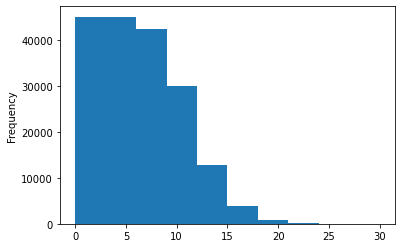

In [218]:
train_df['line_number'].plot.hist(bins=10);
np.percentile(train_df['line_number'], 98)

In [201]:
#use tensorflow to one-hot encoder column
train_line_numbers_onehot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_onehot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_onehot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

print(train_line_numbers_onehot.shape)
train_line_numbers_onehot[:5,:10]

(180040, 15)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)>

In [202]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

18.0

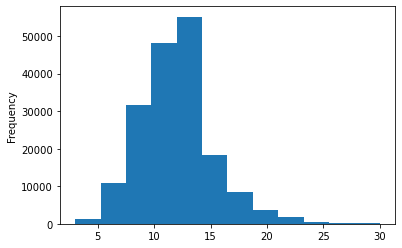

In [208]:
train_df['total_lines'].plot.hist(bins=12);
np.percentile(train_df['total_lines'], 95)

In [216]:
train_total_lines = tf.one_hot(train_df['total_lines'].to_numpy(), depth=18)
val_total_lines = tf.one_hot(val_df['total_lines'].to_numpy(), depth=18)
test_total_lines = tf.one_hot(test_df['total_lines'].to_numpy(), depth=18)

print(train_total_lines.shape)
train_total_lines[:15,:14]

(180040, 18)


<tf.Tensor: shape=(15, 14), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 

### Build Model!!!

In [226]:
#token embbedding model
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name='token_inputs')
text_vector_layer = text_vectorizer(token_inputs)
token_embeder_layer = token_embed(text_vector_layer)
x = layers.Conv1D(64, 4, padding='same')(token_embeder_layer)
x = layers.GlobalMaxPool1D()(x)
token_output = layers.Dense(128, activation='relu')(x)
token_model = keras.Model(token_inputs, token_output)

#char embedding model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vec_layer = char_vectorize(char_inputs)
char_embed_layer = char_embed(char_vec_layer)
x = layers.Bidirectional(layers.LSTM(24))(char_embed_layer)
char_model = keras.Model(char_inputs, x)

#line number model
lines_inputs = layers.Input(shape=(15,),dtype=tf.float32, name='lines_inputs')
x = layers.Dense(32, activation='relu')(lines_inputs)
lines_model = keras.Model(lines_inputs, x)

#total lines model
total_lines_inputs = layers.Input(shape=(18,),dtype=tf.float32, name='total_lines_inputs')
x = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = keras.Model(total_lines_inputs, x)


#concatinate token and char
x = layers.Concatenate(name='token_char_concat')([token_model.output, char_model.output ])
x = layers.Dropout(.3)(x)

#concatinate token_char_concat and lines_model, total_lines_model
tribid = layers.Concatenate(name='tribrid_positional')([lines_model.output, total_lines_model.output, x])

#create output layer
outputs = layers.Dense(5, activation='softmax', name='outputs')(tribid)

#model
model_5 = keras.Model(inputs=[lines_model.input, 
                      total_lines_model.input, 
                      token_model.input, 
                      char_model.input], 
                      outputs=outputs)

model_5.summary()

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['token_inputs[0][0]']           
 ization)                                                                                         
                                                                                                  
 token_embedding (Embedding)    (None, 55, 128)      8299648     ['text_vectorization[9][0]']     
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                        

In [227]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=.2),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

> label_smoothing : decrease some prediction that are very confident (prevent overfitting). [0, 0, 1, 0, 0] --> [.01, .01, .96, .01, .01]

In [232]:
#create dataset
def create_dataset(p1,p2,p3,p4,labels):
    train_token_char_pos = tf.data.Dataset.from_tensor_slices((p1, p2, p3, p4))
    train_token_char_labels = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((train_token_char_pos, train_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_token_char_pos_dataset = create_dataset(train_line_numbers_onehot, train_total_lines, train_sentences, train_char, train_labels)
val_token_char_pos_dataset = create_dataset(val_line_numbers_onehot, val_total_lines, val_sentences, val_char, val_labels)
test_token_char_pos_dataset = create_dataset(test_line_numbers_onehot, test_total_lines, test_sentences, test_char, test_labels)

train_token_char_pos_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [234]:
model_5.fit(
    train_token_char_pos_dataset,
    steps_per_epoch=int(len(train_token_char_pos_dataset)*.1),
    validation_data = val_token_char_pos_dataset,
    validation_steps=int(len(val_token_char_pos_dataset) *.1),
    epochs=3
)

Epoch 1/3
562/562 [==============================] - 124s 207ms/step - loss: 0.9736 - accuracy: 0.8164 - val_loss: 0.9208 - val_accuracy: 0.8464
Epoch 2/3
562/562 [==============================] - 105s 186ms/step - loss: 0.8813 - accuracy: 0.8826 - val_loss: 0.9150 - val_accuracy: 0.8418
Epoch 3/3
562/562 [==============================] - 99s 176ms/step - loss: 0.8651 - accuracy: 0.8888 - val_loss: 0.9051 - val_accuracy: 0.8487


In [235]:
model_5_proba = model_5.predict(val_token_char_pos_dataset)
model_5_preds = tf.argmax(model_5_proba, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 2, 4, 4, 1], dtype=int64)>

In [236]:
model_5_result = evaluate_score(val_labels_, model_5_preds)
model_5_result

{'accuracy': 0.8483053091486826,
 'precision': 0.8491809348058245,
 'recall': 0.8483053091486826,
 'f1_score': 0.847231975000299}

## Compare model result

In [250]:
results = pd.DataFrame({
    'baseline' : baseline_score,
    'conv1D-token':model_1_result,
    'conv1D-char':model_3_result,
    'token-char':model_4_result,
    'token-char-pos':model_5_result
}).T

results

,accuracy,precision,recall,f1_score
baseline,0.721832,0.718647,0.721832,0.698925
conv1D-token,0.798292,0.797459,0.798292,0.795295
conv1D-char,0.629816,0.645227,0.629816,0.625054
token-char,0.802297,0.805304,0.802297,0.803395
token-char-pos,0.848305,0.849181,0.848305,0.847232


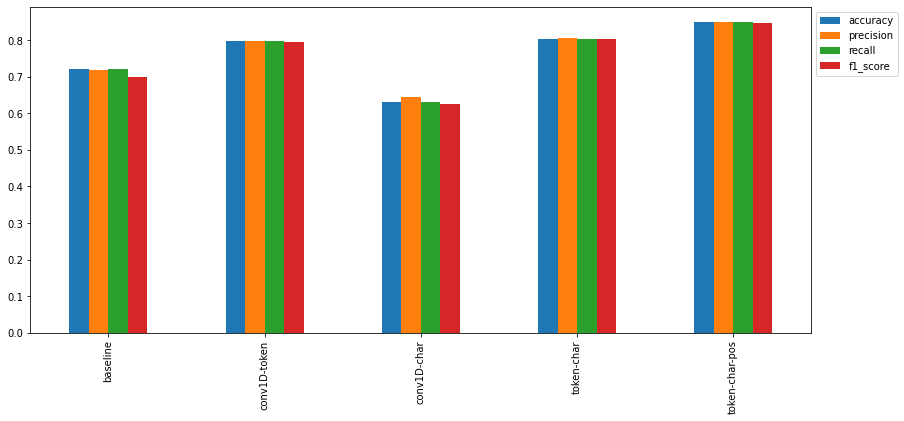

In [260]:
results.plot(kind='bar', figsize=(14,6)).legend(bbox_to_anchor=(1.0, 1.0));

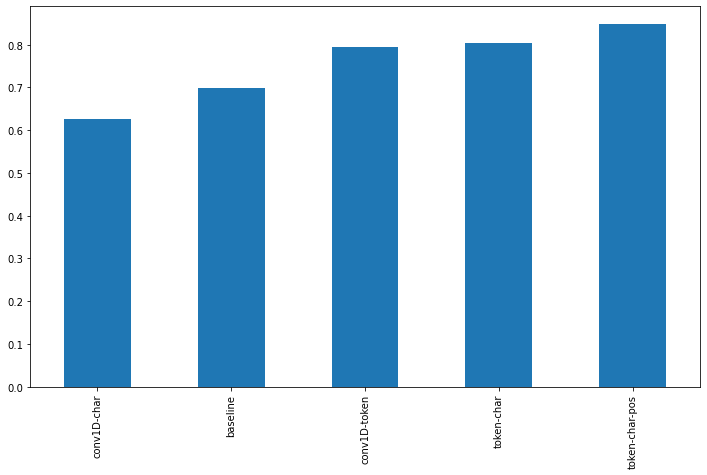

In [264]:
results.sort_values('f1_score', ascending=True)['f1_score'].plot(kind='bar', figsize=(12,7));

## Save and load model

In [273]:
model_5.save('skimlit_tribid_model')

INFO:tensorflow:Assets written to: skimlit_tribid_model\assets


INFO:tensorflow:Assets written to: skimlit_tribid_model\assets


In [274]:
loaded_model = tf.keras.models.load_model('skimlit_tribid_model')
loaded_model

In [275]:
prediction  = tf.argmax(loaded_model.predict(val_token_char_pos_dataset), axis=1)
prediction_result = evaluate_score(val_labels_, prediction)

In [277]:
model_5_result == prediction_result

True